In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [14]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_sample = len(x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_sample

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(train_x.shape[1], 128),      # Increase the number of neurons
            nn.ReLU(),
            nn.Dropout(0.5),                # Add dropout for regularization
            nn.Linear(128, 64),             # Add another layer
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)  
        )
    def forward(self, x):
        return self.net(x)

In [16]:
df = pd.read_csv("adult_with_anonymity_k3.csv")
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,[17-18],Private,10th,[6-7],Never-married,Other-service,Own-child,White,Male,[12-40],United-States,<=50K
1,[17-18],Private,11th,[6-7],Never-married,Sales,Own-child,White,Female,[12-40],United-States,<=50K
2,[17-18],Private,11th,[6-7],Never-married,Handlers-cleaners,Own-child,White,Male,[12-40],United-States,<=50K
3,[17-18],Self-emp-inc,10th,[6-7],Never-married,Craft-repair,Own-child,White,Male,[12-40],United-States,<=50K
4,[19-20],Private,HS-grad,[9-10],Never-married,Sales,Unmarried,Black,Female,[30-60],United-States,<=50K


In [17]:
# Function to apply LabelEncoder on multiple columns
def label_encode_columns(df, columns):
    le = LabelEncoder()
    for column in columns:
        df[column] = le.fit_transform(df[column])
    return df

# Apply LabelEncoder on the specified columns
df_encoded = label_encode_columns(df, df.columns)
df_encoded.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,0,2,0,19,3,6,3,4,1,0,17,0
1,0,2,1,19,3,9,3,4,0,0,17,0
2,0,2,1,19,3,4,3,4,1,0,17,0
3,0,3,0,19,3,1,3,4,1,0,17,0
4,1,2,11,26,3,9,4,2,0,14,17,0


In [18]:
# transform pandas type into numpy type
adult_x = df[['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']].values
adult_y = df['income'].values
print(type(adult_x))
print(adult_x.shape)
print(type(adult_y))
print(adult_y.shape)

<class 'numpy.ndarray'>
(300, 11)
<class 'numpy.ndarray'>
(300,)


In [19]:
# normalize
minmax = MinMaxScaler()
adult_x = minmax.fit_transform(adult_x)

In [20]:
# split dataset into training and validation
train_x, valid_x, train_y, valid_y = train_test_split(adult_x, adult_y, test_size=0.2, random_state=1)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=1)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(240, 11)
(240,)
(30, 11)
(30,)
(30, 11)
(30,)


In [21]:
train_x = torch.tensor(train_x, dtype=torch.float32)
valid_x = torch.tensor(valid_x, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
valid_y = torch.tensor(valid_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

In [22]:
train_set = dataset(train_x, train_y)
valid_set = dataset(valid_x, valid_y)
test_set = dataset(test_x, test_y)
batch_size = 8
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [23]:
device=torch.device('cuda')
step_size=1000
learning_rate = 0.001
epoch = 250

model = Model().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size,0.1)
train_acc_his,train_losses_his,valid_acc_his,valid_losses_his=[],[],[],[]
for i in range(1, epoch+1):
    print('Running Epoch:'+str(i))
    train_correct,train_loss,train_total,valid_correct,valid_loss,valid_total=0,0,0,0,0,0
    model.train()
    for samples,labels in tqdm(train_loader, desc=f'Epoch {i} - Training'):
        samples, labels = samples.to(device), labels.to(device)
        pred = model(samples)
        loss = criterion(pred, labels)
        output_id = torch.max(pred, dim=1)[1]
        train_correct += np.sum(torch.eq(labels, output_id).cpu().numpy())
        train_loss += loss.item()*samples.size(0)
        train_total += samples.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    for samples,labels in valid_loader:
        samples, labels = samples.to(device), labels.to(device)
        pred = model(samples)
        loss = criterion(pred, labels)
        output_id = torch.max(pred, dim=1)[1]
        valid_correct += np.sum(torch.eq(labels, output_id).cpu().numpy())
        valid_loss += loss.item()*samples.size(0)
        valid_total += samples.size(0)
    
    train_acc = train_correct/train_total*100
    train_loss = train_loss/train_total
    valid_acc = valid_correct/valid_total*100
    valid_loss = valid_loss/valid_total
    train_acc_his.append(train_acc)
    train_losses_his.append(train_loss)
    valid_acc_his.append(valid_acc)
    valid_losses_his.append(valid_loss)
    print(f'Training Loss= {train_loss}')
    print(f'Training Acc(%)= {train_acc}')
    print(f'Validation Acc(%)= {valid_acc}')

Model(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
    (6): Softmax(dim=1)
  )
)
Running Epoch:1


Epoch 1 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 634.51it/s]


Training Loss= 0.6911068777243297
Training Acc(%)= 50.416666666666664
Validation Acc(%)= 60.0
Running Epoch:2


Epoch 2 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 617.64it/s]


Training Loss= 0.6764072020848592
Training Acc(%)= 61.25000000000001
Validation Acc(%)= 66.66666666666666
Running Epoch:3


Epoch 3 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 647.61it/s]


Training Loss= 0.6588689664999644
Training Acc(%)= 66.66666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:4


Epoch 4 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 630.36it/s]


Training Loss= 0.6405029118061065
Training Acc(%)= 65.41666666666667
Validation Acc(%)= 70.0
Running Epoch:5


Epoch 5 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 669.59it/s]


Training Loss= 0.6393412411212921
Training Acc(%)= 65.41666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:6


Epoch 6 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 698.68it/s]


Training Loss= 0.6275526960690816
Training Acc(%)= 64.16666666666667
Validation Acc(%)= 70.0
Running Epoch:7


Epoch 7 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 731.71it/s]


Training Loss= 0.621665433049202
Training Acc(%)= 67.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:8


Epoch 8 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 695.53it/s]


Training Loss= 0.6123014887173971
Training Acc(%)= 69.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:9


Epoch 9 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 709.58it/s]


Training Loss= 0.6157665193080902
Training Acc(%)= 69.58333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:10


Epoch 10 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 746.46it/s]


Training Loss= 0.6024310141801834
Training Acc(%)= 68.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:11


Epoch 11 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 734.01it/s]


Training Loss= 0.6020964860916138
Training Acc(%)= 68.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:12


Epoch 12 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 768.40it/s]


Training Loss= 0.614640063047409
Training Acc(%)= 68.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:13


Epoch 13 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.30it/s]


Training Loss= 0.5914555678764979
Training Acc(%)= 69.16666666666667
Validation Acc(%)= 70.0
Running Epoch:14


Epoch 14 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 762.78it/s]


Training Loss= 0.597213809688886
Training Acc(%)= 70.83333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:15


Epoch 15 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 738.16it/s]


Training Loss= 0.5992437660694122
Training Acc(%)= 68.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:16


Epoch 16 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 808.45it/s]


Training Loss= 0.5867146114508311
Training Acc(%)= 70.83333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:17


Epoch 17 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.06it/s]


Training Loss= 0.5896785279115041
Training Acc(%)= 70.41666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:18


Epoch 18 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 772.10it/s]


Training Loss= 0.5884712666273118
Training Acc(%)= 70.83333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:19


Epoch 19 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.29it/s]


Training Loss= 0.5789298196633657
Training Acc(%)= 70.83333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:20


Epoch 20 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.61it/s]


Training Loss= 0.5839110523462295
Training Acc(%)= 70.83333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:21


Epoch 21 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 773.00it/s]


Training Loss= 0.576666185259819
Training Acc(%)= 71.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:22


Epoch 22 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 817.71it/s]


Training Loss= 0.5738587071498235
Training Acc(%)= 72.91666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:23


Epoch 23 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 789.91it/s]


Training Loss= 0.5716837694247564
Training Acc(%)= 74.16666666666667
Validation Acc(%)= 70.0
Running Epoch:24


Epoch 24 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 775.10it/s]


Training Loss= 0.5800748685995738
Training Acc(%)= 74.16666666666667
Validation Acc(%)= 70.0
Running Epoch:25


Epoch 25 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 773.85it/s]


Training Loss= 0.564351745446523
Training Acc(%)= 71.66666666666667
Validation Acc(%)= 70.0
Running Epoch:26


Epoch 26 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.33it/s]


Training Loss= 0.5715886612733205
Training Acc(%)= 69.16666666666667
Validation Acc(%)= 70.0
Running Epoch:27


Epoch 27 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.01it/s]


Training Loss= 0.5555890440940857
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:28


Epoch 28 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 708.03it/s]


Training Loss= 0.5676056275765101
Training Acc(%)= 73.75
Validation Acc(%)= 66.66666666666666
Running Epoch:29


Epoch 29 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.46it/s]


Training Loss= 0.5577919205029805
Training Acc(%)= 74.16666666666667
Validation Acc(%)= 70.0
Running Epoch:30


Epoch 30 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.24it/s]


Training Loss= 0.5611062029997508
Training Acc(%)= 72.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:31


Epoch 31 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 687.41it/s]


Training Loss= 0.5530095756053924
Training Acc(%)= 74.58333333333333
Validation Acc(%)= 70.0
Running Epoch:32


Epoch 32 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 721.58it/s]


Training Loss= 0.5551753630240758
Training Acc(%)= 75.0
Validation Acc(%)= 70.0
Running Epoch:33


Epoch 33 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 684.74it/s]


Training Loss= 0.5526143093903859
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:34


Epoch 34 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.66it/s]


Training Loss= 0.5573839435974757
Training Acc(%)= 75.41666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:35


Epoch 35 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.85it/s]


Training Loss= 0.5474033931891124
Training Acc(%)= 74.58333333333333
Validation Acc(%)= 70.0
Running Epoch:36


Epoch 36 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 717.29it/s]


Training Loss= 0.5367789745330811
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:37


Epoch 37 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 710.18it/s]


Training Loss= 0.5531954785188039
Training Acc(%)= 74.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:38


Epoch 38 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 660.37it/s]


Training Loss= 0.5381394545237224
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:39


Epoch 39 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 689.64it/s]


Training Loss= 0.5292737871408463
Training Acc(%)= 79.16666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:40


Epoch 40 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 716.71it/s]


Training Loss= 0.5480679829915365
Training Acc(%)= 75.0
Validation Acc(%)= 80.0
Running Epoch:41


Epoch 41 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 701.32it/s]


Training Loss= 0.5321336050828298
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:42


Epoch 42 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 703.92it/s]


Training Loss= 0.5468752145767212
Training Acc(%)= 72.5
Validation Acc(%)= 73.33333333333333
Running Epoch:43


Epoch 43 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 741.63it/s]


Training Loss= 0.5369624962409337
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:44


Epoch 44 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.26it/s]


Training Loss= 0.5287946671247482
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:45


Epoch 45 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.12it/s]


Training Loss= 0.5329851150512696
Training Acc(%)= 77.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:46


Epoch 46 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 756.48it/s]


Training Loss= 0.5264507114887238
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:47


Epoch 47 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 739.25it/s]


Training Loss= 0.5212299793958663
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:48


Epoch 48 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 725.53it/s]


Training Loss= 0.5279968609412511
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:49


Epoch 49 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 744.06it/s]


Training Loss= 0.5376037389039994
Training Acc(%)= 76.25
Validation Acc(%)= 66.66666666666666
Running Epoch:50


Epoch 50 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 723.20it/s]


Training Loss= 0.533801888426145
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:51


Epoch 51 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 727.45it/s]


Training Loss= 0.5381336241960526
Training Acc(%)= 77.5
Validation Acc(%)= 76.66666666666667
Running Epoch:52


Epoch 52 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.67it/s]


Training Loss= 0.508196743329366
Training Acc(%)= 81.25
Validation Acc(%)= 66.66666666666666
Running Epoch:53


Epoch 53 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 723.26it/s]


Training Loss= 0.5190163801113764
Training Acc(%)= 78.75
Validation Acc(%)= 66.66666666666666
Running Epoch:54


Epoch 54 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 766.23it/s]


Training Loss= 0.5178961704174677
Training Acc(%)= 77.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:55


Epoch 55 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 703.62it/s]


Training Loss= 0.5145755271116893
Training Acc(%)= 79.16666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:56


Epoch 56 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 724.33it/s]


Training Loss= 0.5313686947027842
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:57


Epoch 57 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 768.13it/s]


Training Loss= 0.5307300080855687
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:58


Epoch 58 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 718.72it/s]


Training Loss= 0.5032199323177338
Training Acc(%)= 81.25
Validation Acc(%)= 66.66666666666666
Running Epoch:59


Epoch 59 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 703.46it/s]


Training Loss= 0.5031445225079855
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:60


Epoch 60 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 735.77it/s]


Training Loss= 0.5248161792755127
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:61


Epoch 61 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.27it/s]


Training Loss= 0.506699322660764
Training Acc(%)= 77.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:62


Epoch 62 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 743.07it/s]


Training Loss= 0.5113932500282924
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 70.0
Running Epoch:63


Epoch 63 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.17it/s]


Training Loss= 0.5095983942349752
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:64


Epoch 64 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.13it/s]


Training Loss= 0.5112681319316228
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 70.0
Running Epoch:65


Epoch 65 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 710.92it/s]


Training Loss= 0.5052590330441793
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 70.0
Running Epoch:66


Epoch 66 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.59it/s]


Training Loss= 0.5060928940773011
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 70.0
Running Epoch:67


Epoch 67 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 747.22it/s]


Training Loss= 0.49754174749056496
Training Acc(%)= 81.25
Validation Acc(%)= 70.0
Running Epoch:68


Epoch 68 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 720.38it/s]


Training Loss= 0.5029865483442942
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 70.0
Running Epoch:69


Epoch 69 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 747.35it/s]


Training Loss= 0.5082927783330281
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:70


Epoch 70 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.72it/s]


Training Loss= 0.5110501140356064
Training Acc(%)= 78.75
Validation Acc(%)= 66.66666666666666
Running Epoch:71


Epoch 71 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 801.20it/s]


Training Loss= 0.4845133145650228
Training Acc(%)= 81.25
Validation Acc(%)= 70.0
Running Epoch:72


Epoch 72 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.64it/s]


Training Loss= 0.5002807537714641
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 70.0
Running Epoch:73


Epoch 73 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 729.05it/s]


Training Loss= 0.49411013424396516
Training Acc(%)= 81.25
Validation Acc(%)= 66.66666666666666
Running Epoch:74


Epoch 74 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 678.91it/s]


Training Loss= 0.5089822093645732
Training Acc(%)= 80.0
Validation Acc(%)= 70.0
Running Epoch:75


Epoch 75 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 698.02it/s]


Training Loss= 0.4999781092007955
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 70.0
Running Epoch:76


Epoch 76 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 657.37it/s]


Training Loss= 0.489425328373909
Training Acc(%)= 82.5
Validation Acc(%)= 66.66666666666666
Running Epoch:77


Epoch 77 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 713.06it/s]


Training Loss= 0.48832973341147107
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:78


Epoch 78 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 679.32it/s]


Training Loss= 0.5018040041128794
Training Acc(%)= 81.25
Validation Acc(%)= 63.33333333333333
Running Epoch:79


Epoch 79 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 648.02it/s]


Training Loss= 0.49307065705458325
Training Acc(%)= 81.25
Validation Acc(%)= 63.33333333333333
Running Epoch:80


Epoch 80 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 728.49it/s]


Training Loss= 0.48782057662804923
Training Acc(%)= 82.5
Validation Acc(%)= 63.33333333333333
Running Epoch:81


Epoch 81 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.50it/s]


Training Loss= 0.4769730190436045
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:82


Epoch 82 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 715.23it/s]


Training Loss= 0.4986276427904765
Training Acc(%)= 81.25
Validation Acc(%)= 66.66666666666666
Running Epoch:83


Epoch 83 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.30it/s]


Training Loss= 0.49439220627148944
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:84


Epoch 84 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 741.96it/s]


Training Loss= 0.48521141906579335
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:85


Epoch 85 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 721.63it/s]


Training Loss= 0.4811743100484212
Training Acc(%)= 83.75
Validation Acc(%)= 63.33333333333333
Running Epoch:86


Epoch 86 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 738.71it/s]


Training Loss= 0.4828265905380249
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:87


Epoch 87 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.64it/s]


Training Loss= 0.4649526615937551
Training Acc(%)= 85.0
Validation Acc(%)= 63.33333333333333
Running Epoch:88


Epoch 88 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 710.61it/s]


Training Loss= 0.47562411427497864
Training Acc(%)= 83.75
Validation Acc(%)= 66.66666666666666
Running Epoch:89


Epoch 89 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.94it/s]


Training Loss= 0.4947057088216146
Training Acc(%)= 83.75
Validation Acc(%)= 63.33333333333333
Running Epoch:90


Epoch 90 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 717.36it/s]


Training Loss= 0.4914574464162191
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:91


Epoch 91 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 708.98it/s]


Training Loss= 0.46709500153859457
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:92


Epoch 92 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 663.13it/s]


Training Loss= 0.4680173933506012
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:93


Epoch 93 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 618.84it/s]


Training Loss= 0.4782083104054133
Training Acc(%)= 83.75
Validation Acc(%)= 66.66666666666666
Running Epoch:94


Epoch 94 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 699.99it/s]


Training Loss= 0.4973990927139918
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:95


Epoch 95 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 749.69it/s]


Training Loss= 0.4943828364213308
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:96


Epoch 96 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.46it/s]


Training Loss= 0.4890976349512736
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:97


Epoch 97 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 730.89it/s]


Training Loss= 0.4818654050429662
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:98


Epoch 98 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 666.21it/s]


Training Loss= 0.4807056387265523
Training Acc(%)= 83.75
Validation Acc(%)= 63.33333333333333
Running Epoch:99


Epoch 99 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 644.73it/s]


Training Loss= 0.48598387638727825
Training Acc(%)= 81.25
Validation Acc(%)= 63.33333333333333
Running Epoch:100


Epoch 100 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 654.76it/s]


Training Loss= 0.4772352268298467
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:101


Epoch 101 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 682.30it/s]


Training Loss= 0.4750733812650045
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:102


Epoch 102 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.85it/s]


Training Loss= 0.47024933298428856
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:103


Epoch 103 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.83it/s]


Training Loss= 0.4719184547662735
Training Acc(%)= 83.75
Validation Acc(%)= 63.33333333333333
Running Epoch:104


Epoch 104 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.24it/s]


Training Loss= 0.4752738654613495
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:105


Epoch 105 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.30it/s]


Training Loss= 0.48309134542942045
Training Acc(%)= 83.75
Validation Acc(%)= 63.33333333333333
Running Epoch:106


Epoch 106 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 762.69it/s]


Training Loss= 0.5045711139837901
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:107


Epoch 107 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 688.91it/s]


Training Loss= 0.47046877443790436
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:108


Epoch 108 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 718.95it/s]


Training Loss= 0.48888006110986076
Training Acc(%)= 81.25
Validation Acc(%)= 63.33333333333333
Running Epoch:109


Epoch 109 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 717.42it/s]


Training Loss= 0.4769622425238291
Training Acc(%)= 82.5
Validation Acc(%)= 70.0
Running Epoch:110


Epoch 110 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.74it/s]


Training Loss= 0.46151934067408246
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:111


Epoch 111 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 720.24it/s]


Training Loss= 0.47359559237957
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:112


Epoch 112 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.28it/s]


Training Loss= 0.4672775983810425
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:113


Epoch 113 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 601.98it/s]


Training Loss= 0.46564778288205466
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:114


Epoch 114 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 582.30it/s]


Training Loss= 0.46781203349431355
Training Acc(%)= 85.0
Validation Acc(%)= 63.33333333333333
Running Epoch:115


Epoch 115 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 679.14it/s]


Training Loss= 0.44894242386023203
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:116


Epoch 116 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.27it/s]


Training Loss= 0.4705990453561147
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:117


Epoch 117 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 721.07it/s]


Training Loss= 0.4633029967546463
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:118


Epoch 118 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.26it/s]


Training Loss= 0.4838021198908488
Training Acc(%)= 81.25
Validation Acc(%)= 63.33333333333333
Running Epoch:119


Epoch 119 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 772.30it/s]


Training Loss= 0.48793282608191174
Training Acc(%)= 81.25
Validation Acc(%)= 63.33333333333333
Running Epoch:120


Epoch 120 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.73it/s]


Training Loss= 0.4556878536939621
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:121


Epoch 121 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.77it/s]


Training Loss= 0.467853585879008
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:122


Epoch 122 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 730.85it/s]


Training Loss= 0.46728002627690635
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:123


Epoch 123 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 729.75it/s]


Training Loss= 0.46422985196113586
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:124


Epoch 124 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.12it/s]


Training Loss= 0.45520210862159727
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:125


Epoch 125 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 758.56it/s]


Training Loss= 0.45895598928133646
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:126


Epoch 126 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 730.30it/s]


Training Loss= 0.4612271954615911
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:127


Epoch 127 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 785.39it/s]


Training Loss= 0.4663620968659719
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:128


Epoch 128 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 728.50it/s]


Training Loss= 0.466939714550972
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:129


Epoch 129 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 683.48it/s]


Training Loss= 0.4587483793497086
Training Acc(%)= 85.0
Validation Acc(%)= 70.0
Running Epoch:130


Epoch 130 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.07it/s]


Training Loss= 0.4698435664176941
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:131


Epoch 131 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 719.42it/s]


Training Loss= 0.46900405089060465
Training Acc(%)= 83.75
Validation Acc(%)= 66.66666666666666
Running Epoch:132


Epoch 132 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 728.73it/s]


Training Loss= 0.4532631168762843
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:133


Epoch 133 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 751.06it/s]


Training Loss= 0.4578749974568685
Training Acc(%)= 85.0
Validation Acc(%)= 63.33333333333333
Running Epoch:134


Epoch 134 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.14it/s]


Training Loss= 0.46377070049444835
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:135


Epoch 135 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.65it/s]


Training Loss= 0.4497629076242447
Training Acc(%)= 86.25
Validation Acc(%)= 63.33333333333333
Running Epoch:136


Epoch 136 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.42it/s]


Training Loss= 0.4588942925135295
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:137


Epoch 137 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.98it/s]


Training Loss= 0.44977968831857046
Training Acc(%)= 86.25
Validation Acc(%)= 66.66666666666666
Running Epoch:138


Epoch 138 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 672.71it/s]


Training Loss= 0.47085854212443035
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:139


Epoch 139 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 709.31it/s]


Training Loss= 0.44389394919077557
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 63.33333333333333
Running Epoch:140


Epoch 140 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 751.34it/s]


Training Loss= 0.45693932672341664
Training Acc(%)= 85.0
Validation Acc(%)= 63.33333333333333
Running Epoch:141


Epoch 141 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.42it/s]


Training Loss= 0.44950388073921205
Training Acc(%)= 87.5
Validation Acc(%)= 66.66666666666666
Running Epoch:142


Epoch 142 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.13it/s]


Training Loss= 0.46437564492225647
Training Acc(%)= 83.75
Validation Acc(%)= 66.66666666666666
Running Epoch:143


Epoch 143 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 709.36it/s]


Training Loss= 0.45408306221167244
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:144


Epoch 144 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 785.48it/s]


Training Loss= 0.46419802407423655
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:145


Epoch 145 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 742.28it/s]


Training Loss= 0.4520147641499837
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:146


Epoch 146 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.63it/s]


Training Loss= 0.4712220162153244
Training Acc(%)= 83.75
Validation Acc(%)= 66.66666666666666
Running Epoch:147


Epoch 147 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.40it/s]


Training Loss= 0.4468259731928507
Training Acc(%)= 87.5
Validation Acc(%)= 63.33333333333333
Running Epoch:148


Epoch 148 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.69it/s]


Training Loss= 0.4500300198793411
Training Acc(%)= 85.0
Validation Acc(%)= 63.33333333333333
Running Epoch:149


Epoch 149 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.95it/s]


Training Loss= 0.4537721951802572
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:150


Epoch 150 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.18it/s]


Training Loss= 0.4576658676067988
Training Acc(%)= 86.25
Validation Acc(%)= 66.66666666666666
Running Epoch:151


Epoch 151 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 731.84it/s]


Training Loss= 0.46470100184281665
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:152


Epoch 152 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 719.22it/s]


Training Loss= 0.451580939690272
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:153


Epoch 153 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.91it/s]


Training Loss= 0.45469373762607573
Training Acc(%)= 86.25
Validation Acc(%)= 63.33333333333333
Running Epoch:154


Epoch 154 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 715.45it/s]


Training Loss= 0.4504651536544164
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:155


Epoch 155 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 698.91it/s]


Training Loss= 0.45960204005241395
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:156


Epoch 156 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 787.75it/s]


Training Loss= 0.45279056231180825
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:157


Epoch 157 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 683.30it/s]


Training Loss= 0.4595454196135203
Training Acc(%)= 85.0
Validation Acc(%)= 63.33333333333333
Running Epoch:158


Epoch 158 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.13it/s]


Training Loss= 0.4411415060361226
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:159


Epoch 159 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 673.04it/s]


Training Loss= 0.436287318666776
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:160


Epoch 160 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 799.20it/s]


Training Loss= 0.4483015845219294
Training Acc(%)= 86.25
Validation Acc(%)= 63.33333333333333
Running Epoch:161


Epoch 161 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.31it/s]


Training Loss= 0.46880282163619996
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:162


Epoch 162 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 703.69it/s]


Training Loss= 0.4488181620836258
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:163


Epoch 163 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 732.28it/s]


Training Loss= 0.44237835506598155
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:164


Epoch 164 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.84it/s]


Training Loss= 0.44351043105125426
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:165


Epoch 165 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.90it/s]


Training Loss= 0.45796962479750314
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 63.33333333333333
Running Epoch:166


Epoch 166 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 677.88it/s]


Training Loss= 0.44612318674723306
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:167


Epoch 167 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.84it/s]


Training Loss= 0.45980437298615773
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:168


Epoch 168 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 742.98it/s]


Training Loss= 0.45360527038574217
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:169


Epoch 169 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 769.60it/s]


Training Loss= 0.43661389450232185
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:170


Epoch 170 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 768.22it/s]


Training Loss= 0.4530783861875534
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:171


Epoch 171 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.88it/s]


Training Loss= 0.44879705806573233
Training Acc(%)= 85.0
Validation Acc(%)= 66.66666666666666
Running Epoch:172


Epoch 172 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 700.78it/s]


Training Loss= 0.4686327228943507
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 70.0
Running Epoch:173


Epoch 173 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 729.22it/s]


Training Loss= 0.4471541206041972
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 70.0
Running Epoch:174


Epoch 174 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 691.68it/s]


Training Loss= 0.4378362645705541
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:175


Epoch 175 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.92it/s]


Training Loss= 0.4470822552839915
Training Acc(%)= 87.5
Validation Acc(%)= 63.33333333333333
Running Epoch:176


Epoch 176 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 739.15it/s]


Training Loss= 0.4500966380039851
Training Acc(%)= 86.25
Validation Acc(%)= 63.33333333333333
Running Epoch:177


Epoch 177 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 714.23it/s]


Training Loss= 0.46824504137039186
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:178


Epoch 178 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.99it/s]


Training Loss= 0.4496378928422928
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:179


Epoch 179 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 773.52it/s]


Training Loss= 0.44433093070983887
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:180


Epoch 180 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 794.12it/s]


Training Loss= 0.46119014322757723
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:181


Epoch 181 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.61it/s]


Training Loss= 0.4360866963863373
Training Acc(%)= 88.75
Validation Acc(%)= 66.66666666666666
Running Epoch:182


Epoch 182 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 689.81it/s]


Training Loss= 0.4518407960732778
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:183


Epoch 183 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.97it/s]


Training Loss= 0.45305223365624747
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 66.66666666666666
Running Epoch:184


Epoch 184 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 735.03it/s]


Training Loss= 0.44965206682682035
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:185


Epoch 185 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 715.43it/s]


Training Loss= 0.45836264789104464
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:186


Epoch 186 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 734.27it/s]


Training Loss= 0.44351256887118023
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:187


Epoch 187 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 728.57it/s]


Training Loss= 0.43091850678126015
Training Acc(%)= 88.75
Validation Acc(%)= 63.33333333333333
Running Epoch:188


Epoch 188 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 763.18it/s]


Training Loss= 0.43880684971809386
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:189


Epoch 189 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 747.36it/s]


Training Loss= 0.450366398692131
Training Acc(%)= 86.25
Validation Acc(%)= 66.66666666666666
Running Epoch:190


Epoch 190 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 713.37it/s]


Training Loss= 0.4477656940619151
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 56.666666666666664
Running Epoch:191


Epoch 191 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 725.81it/s]


Training Loss= 0.4488556404908498
Training Acc(%)= 86.25
Validation Acc(%)= 63.33333333333333
Running Epoch:192


Epoch 192 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.53it/s]


Training Loss= 0.4554997424284617
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:193


Epoch 193 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.89it/s]


Training Loss= 0.45789941449960075
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:194


Epoch 194 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.53it/s]


Training Loss= 0.437710240483284
Training Acc(%)= 87.5
Validation Acc(%)= 66.66666666666666
Running Epoch:195


Epoch 195 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 676.58it/s]


Training Loss= 0.42294370035330453
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 66.66666666666666
Running Epoch:196


Epoch 196 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 782.24it/s]


Training Loss= 0.435630139708519
Training Acc(%)= 87.5
Validation Acc(%)= 66.66666666666666
Running Epoch:197


Epoch 197 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.92it/s]


Training Loss= 0.430098956823349
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:198


Epoch 198 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 697.42it/s]


Training Loss= 0.43978447616100313
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:199


Epoch 199 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 723.78it/s]


Training Loss= 0.4475892633199692
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:200


Epoch 200 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 646.65it/s]


Training Loss= 0.437981445590655
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:201


Epoch 201 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 705.70it/s]


Training Loss= 0.44052141110102333
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:202


Epoch 202 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.79it/s]


Training Loss= 0.44199806650479634
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:203


Epoch 203 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.17it/s]


Training Loss= 0.4409211258093516
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:204


Epoch 204 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.05it/s]


Training Loss= 0.44603264331817627
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:205


Epoch 205 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 748.66it/s]


Training Loss= 0.4420086642106374
Training Acc(%)= 87.5
Validation Acc(%)= 63.33333333333333
Running Epoch:206


Epoch 206 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 744.08it/s]


Training Loss= 0.43212332725524905
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:207


Epoch 207 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.92it/s]


Training Loss= 0.4398271044095357
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:208


Epoch 208 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 754.92it/s]


Training Loss= 0.4425749192635218
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:209


Epoch 209 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.60it/s]


Training Loss= 0.43554958899815877
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 56.666666666666664
Running Epoch:210


Epoch 210 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 779.42it/s]


Training Loss= 0.4483770797650019
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:211


Epoch 211 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 254.15it/s]


Training Loss= 0.41266918877760567
Training Acc(%)= 91.25
Validation Acc(%)= 63.33333333333333
Running Epoch:212


Epoch 212 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 713.22it/s]


Training Loss= 0.4365622808535894
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:213


Epoch 213 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 787.33it/s]


Training Loss= 0.43420644402503966
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:214


Epoch 214 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.16it/s]


Training Loss= 0.4295503189166387
Training Acc(%)= 87.5
Validation Acc(%)= 60.0
Running Epoch:215


Epoch 215 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 676.49it/s]


Training Loss= 0.43014132579167685
Training Acc(%)= 87.5
Validation Acc(%)= 60.0
Running Epoch:216


Epoch 216 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.51it/s]


Training Loss= 0.4438931971788406
Training Acc(%)= 87.5
Validation Acc(%)= 63.33333333333333
Running Epoch:217


Epoch 217 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 742.84it/s]


Training Loss= 0.4349431256453196
Training Acc(%)= 87.5
Validation Acc(%)= 60.0
Running Epoch:218


Epoch 218 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 746.00it/s]


Training Loss= 0.442807744940122
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:219


Epoch 219 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 728.55it/s]


Training Loss= 0.4314497580130895
Training Acc(%)= 88.75
Validation Acc(%)= 63.33333333333333
Running Epoch:220


Epoch 220 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 755.61it/s]


Training Loss= 0.43150109648704527
Training Acc(%)= 88.75
Validation Acc(%)= 60.0
Running Epoch:221


Epoch 221 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.19it/s]


Training Loss= 0.43604426781336464
Training Acc(%)= 87.5
Validation Acc(%)= 56.666666666666664
Running Epoch:222


Epoch 222 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 734.08it/s]


Training Loss= 0.42348663608233134
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 60.0
Running Epoch:223


Epoch 223 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 775.72it/s]


Training Loss= 0.43858760595321655
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 50.0
Running Epoch:224


Epoch 224 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 777.08it/s]


Training Loss= 0.4225004514058431
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 60.0
Running Epoch:225


Epoch 225 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 731.28it/s]


Training Loss= 0.44479356904824574
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:226


Epoch 226 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.30it/s]


Training Loss= 0.42828716735045114
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 60.0
Running Epoch:227


Epoch 227 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.25it/s]


Training Loss= 0.44081449111302695
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 60.0
Running Epoch:228


Epoch 228 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 746.77it/s]


Training Loss= 0.432009827097257
Training Acc(%)= 86.25
Validation Acc(%)= 60.0
Running Epoch:229


Epoch 229 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 712.07it/s]


Training Loss= 0.42715740700562793
Training Acc(%)= 88.75
Validation Acc(%)= 63.33333333333333
Running Epoch:230


Epoch 230 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 742.49it/s]


Training Loss= 0.42449169953664145
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 60.0
Running Epoch:231


Epoch 231 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.70it/s]


Training Loss= 0.4291970878839493
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 66.66666666666666
Running Epoch:232


Epoch 232 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 710.00it/s]


Training Loss= 0.43104242781798047
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 60.0
Running Epoch:233


Epoch 233 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 782.37it/s]


Training Loss= 0.43406966626644133
Training Acc(%)= 88.75
Validation Acc(%)= 60.0
Running Epoch:234


Epoch 234 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 783.62it/s]


Training Loss= 0.4243589103221893
Training Acc(%)= 88.75
Validation Acc(%)= 60.0
Running Epoch:235


Epoch 235 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.65it/s]


Training Loss= 0.4351903875668844
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 56.666666666666664
Running Epoch:236


Epoch 236 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 720.73it/s]


Training Loss= 0.4181606451670329
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 56.666666666666664
Running Epoch:237


Epoch 237 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 730.74it/s]


Training Loss= 0.4406324485937754
Training Acc(%)= 87.5
Validation Acc(%)= 63.33333333333333
Running Epoch:238


Epoch 238 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.10it/s]


Training Loss= 0.4339824835459391
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 66.66666666666666
Running Epoch:239


Epoch 239 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 660.77it/s]


Training Loss= 0.435237913330396
Training Acc(%)= 87.5
Validation Acc(%)= 63.33333333333333
Running Epoch:240


Epoch 240 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 721.13it/s]


Training Loss= 0.4506862133741379
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 63.33333333333333
Running Epoch:241


Epoch 241 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.34it/s]


Training Loss= 0.44641939202944436
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 63.33333333333333
Running Epoch:242


Epoch 242 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 731.18it/s]


Training Loss= 0.4317699839671453
Training Acc(%)= 88.75
Validation Acc(%)= 60.0
Running Epoch:243


Epoch 243 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 774.53it/s]


Training Loss= 0.4242214888334274
Training Acc(%)= 88.75
Validation Acc(%)= 63.33333333333333
Running Epoch:244


Epoch 244 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 729.52it/s]


Training Loss= 0.41549613575140637
Training Acc(%)= 89.58333333333334
Validation Acc(%)= 63.33333333333333
Running Epoch:245


Epoch 245 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 769.86it/s]


Training Loss= 0.42086890935897825
Training Acc(%)= 90.0
Validation Acc(%)= 63.33333333333333
Running Epoch:246


Epoch 246 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 708.03it/s]


Training Loss= 0.4110016137361526
Training Acc(%)= 90.41666666666667
Validation Acc(%)= 56.666666666666664
Running Epoch:247


Epoch 247 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 740.08it/s]


Training Loss= 0.4340222915013631
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 63.33333333333333
Running Epoch:248


Epoch 248 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.04it/s]


Training Loss= 0.4213044981161753
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 60.0
Running Epoch:249


Epoch 249 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.47it/s]


Training Loss= 0.4268267333507538
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 60.0
Running Epoch:250


Epoch 250 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 718.59it/s]

Training Loss= 0.444927911957105
Training Acc(%)= 86.25
Validation Acc(%)= 60.0


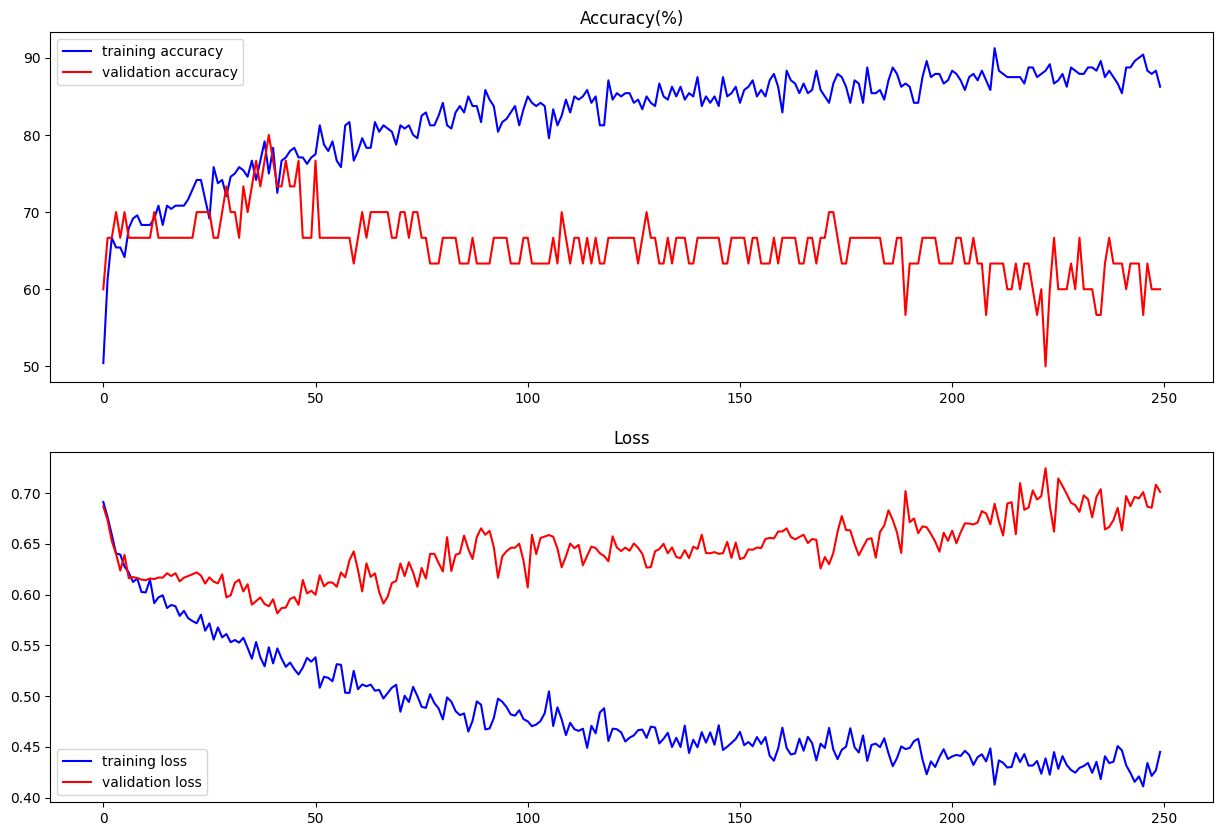

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(train_acc_his,'b',label='training accuracy')
plt.plot(valid_acc_his,'r',label='validation accuracy')
plt.title('Accuracy(%)')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(train_losses_his,'b',label='training loss')
plt.plot(valid_losses_his,'r',label='validation loss')
plt.title('Loss')
plt.legend(loc='best')
plt.show()
#plt.savefig("training and validation fig.jpg")

## Prediction (After Training)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images,labbels = images.to(device), labels.to(device)
        output = model(images).to(device)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# all_labels: ground truth labels
# all_preds: predicted labels

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print the results
print(f'Confusion matrix: {cm}\n')
print(f"Accuracy: {accuracy:.2f}\n")
print(f"Precision (per class): {precision}\n")
print(f"Recall (per class): {recall}\n")

Confusion matrix: [[10  5]
 [ 4 11]]

Accuracy: 0.70

Precision (per class): [0.71428571 0.6875    ]

Recall (per class): [0.66666667 0.73333333]



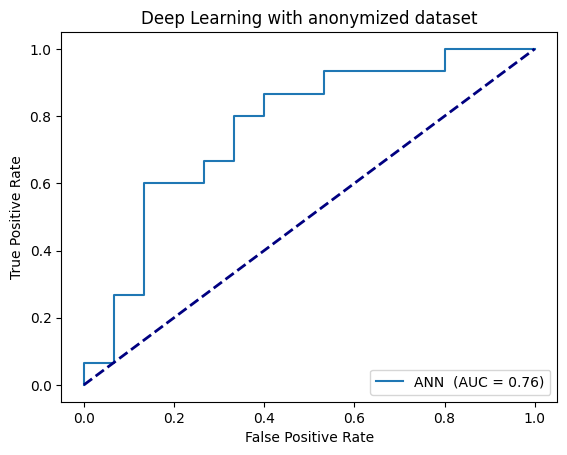

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
import numpy as np
import torch

all_probs = []
all_labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images).to(device)  # Get model outputs
        
        #print(f'output: {output}')
        # Assuming output is a tensor of shape (batch_size, num_classes)
        #probs = torch.softmax(output, dim=1)  # Get predicted probabilities
        #print(f'probs: {probs}')
        
        # Collect all probabilities
        all_probs.extend(output.cpu().numpy())
        
        # Collect true labels
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
 
np.save('k3_all_labels', all_labels)
np.save('k3_all_probs', all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='ANN ')

display.plot()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Deep Learning with anonymized dataset')
plt.legend(loc='lower right')
plt.show()


## Different k value ROC curve

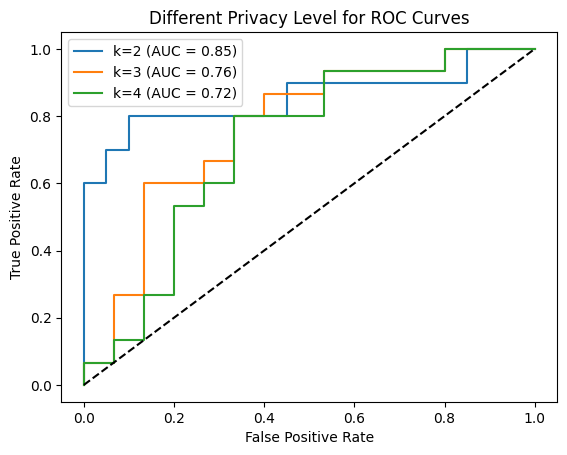

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

# load numpy file
k2_all_labels = np.load('k2_all_labels.npy')
k2_all_probs = np.load('k2_all_probs.npy')
k3_all_labels = np.load('k3_all_labels.npy')
k3_all_probs = np.load('k3_all_probs.npy')
k4_all_labels = np.load('k4_all_labels.npy')
k4_all_probs = np.load('k4_all_probs.npy')

# Compute ROC curve and ROC area for each set of scores
fpr1, tpr1, _ = roc_curve(k2_all_labels, k2_all_probs[:, 1])
fpr2, tpr2, _ = roc_curve(k3_all_labels, k3_all_probs[:, 1])
fpr3, tpr3, _ = roc_curve(k4_all_labels, k4_all_probs[:, 1])

auc1 = roc_auc_score(k2_all_labels, k2_all_probs[:, 1])
auc2 = roc_auc_score(k3_all_labels, k3_all_probs[:, 1])
auc3 = roc_auc_score(k4_all_labels, k4_all_probs[:, 1])

# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Create RocCurveDisplay objects
roc_display1 = RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax, name=f'k=2 (AUC = {auc1:.2f})')
roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax, name=f'k=3 (AUC = {auc2:.2f})')
roc_display3 = RocCurveDisplay(fpr=fpr3, tpr=tpr3).plot(ax=ax, name=f'k=4 (AUC = {auc3:.2f})')

# Customize the plot
ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Different Privacy Level for ROC Curves')
ax.legend()

# Show the plot
plt.show()
